In [26]:
import pandas as pd
import sys
sys.path.append('../utils')
import visualization as visualization
import generic as generic
import project_utils as project_utils
import numpy as np
import matplotlib.pyplot as plt
import importlib
epidemy_years = ['2012_13', '2015_16', '2018_19', '2023_24']



### Load Data

In [27]:
dengue_data = pd.read_csv('../data/processed/dengue_data_with_coordinates.csv')
daily_ovitraps = pd.read_csv('../data/processed/daily_ovitraps.csv',index_col=0, parse_dates=True)
ovitraps_data = pd.read_csv('../data/processed/ovitraps_data_with_coordinates.csv')


### Process Data

In [28]:
# DELETE AFTER DVC PROCESSING
dengue_data = project_utils.process_dengue(dengue_data)

# Dengue data
daily_dengue_data = project_utils.get_daily_dengue(dengue_data)

# ovitraps data
daily_ovitraps_sum = daily_ovitraps.sum(axis=1)
daily_ovitraps_mean = daily_ovitraps.mean(axis=1)

In [29]:
# Get the days for each epidemy year  put them in flat list
day_anoepid_dengue = project_utils.get_epidemic_years_date_ranges_dengue(dengue_data)
epidemy_years_days_dengue = {year: days for year, days in day_anoepid_dengue.items() if year in epidemy_years}
epidemy_date_range_dengue = [
    pd.date_range(start=epidemy_years_days_dengue[year][0], end=epidemy_years_days_dengue[year][-1])
    for year in epidemy_years
]
epidemy_days_flat_dengue = [day for period in epidemy_date_range_dengue for day in period]


In [30]:
# Add anoepid to daily_dengue
daily_dengue_data_with_anoepid = daily_dengue_data.copy()
daily_dengue_data_with_anoepid = pd.DataFrame(daily_dengue_data_with_anoepid, index = daily_dengue_data_with_anoepid.index)
daily_dengue_data_with_anoepid.rename(columns={0: 'cases'}, inplace=True)

aux_list = [] 
for day in daily_dengue_data_with_anoepid.index:
    for key, value in day_anoepid_dengue.items():
        if day in value:
            aux_list.append(key)
daily_dengue_data_with_anoepid['anoepid'] = aux_list

### Plot data

#### Dengue

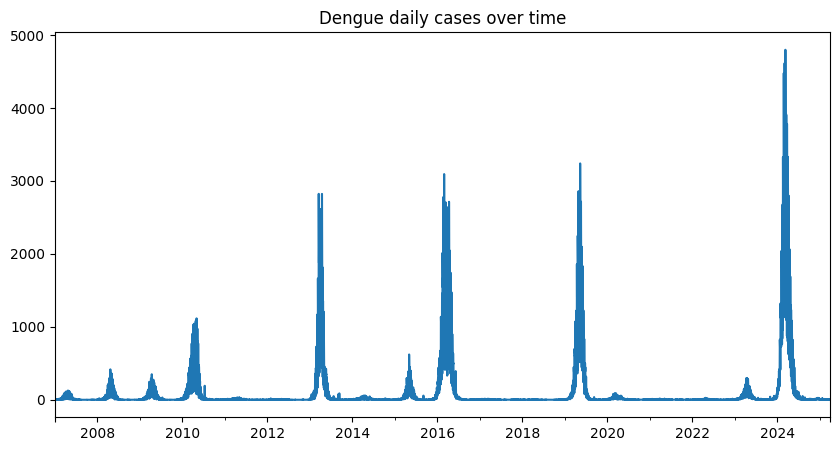

In [31]:
daily_dengue_data.plot(kind='line', figsize=(10, 5), title='Dengue daily cases over time')
plt.show()


#### Ovitraps

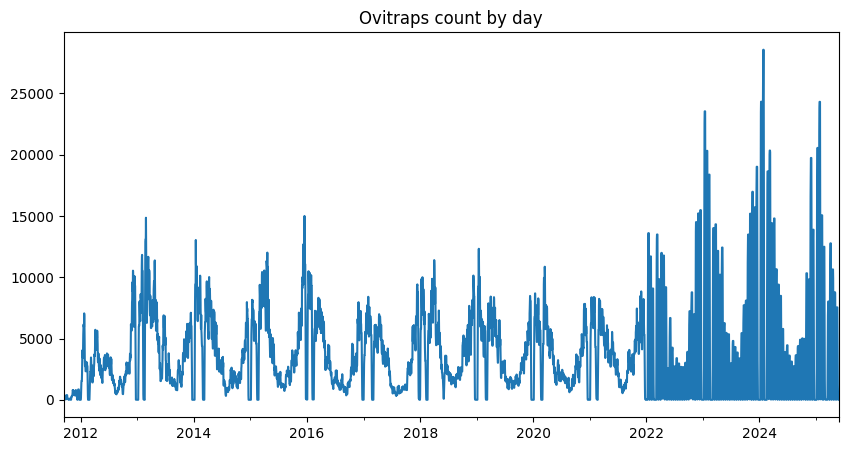

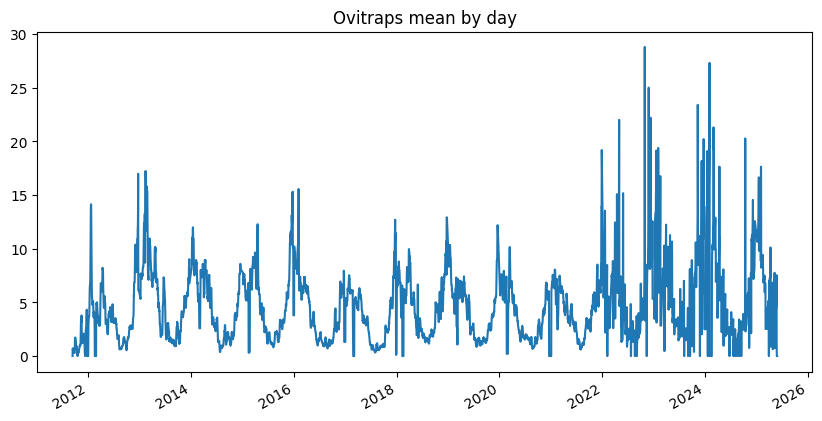

In [32]:
daily_ovitraps_sum.plot(kind='line', figsize=(10, 5), title='Ovitraps count by day')
plt.show()
daily_ovitraps_mean.dropna().plot(kind='line', figsize=(10, 5), title='Ovitraps mean by day')
plt.show()

# Correlation Analysis

### All years

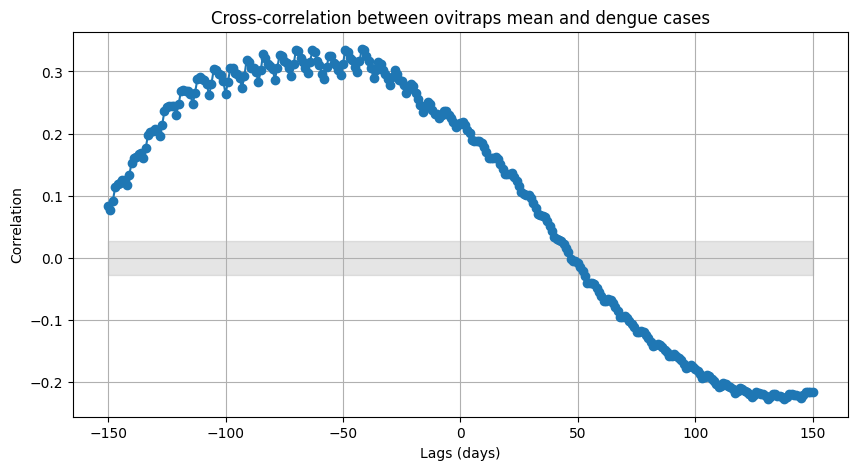

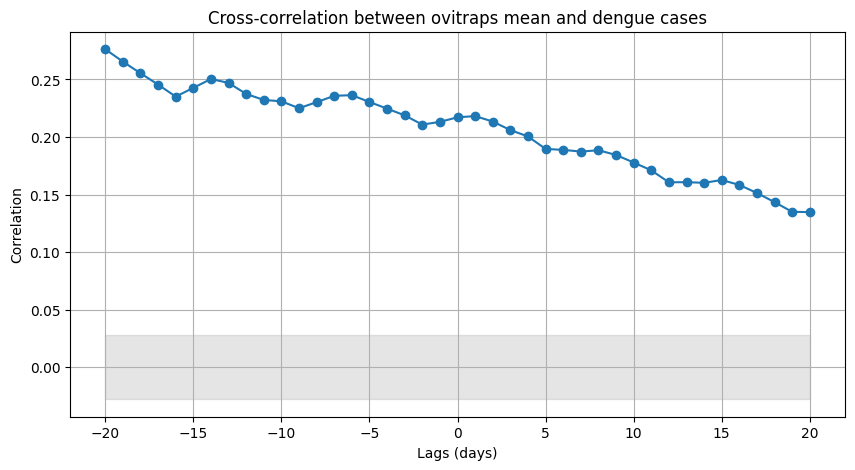

In [33]:
generic.plot_cross_correlation(
    series_1 = daily_ovitraps_mean,
    series_2 = daily_dengue_data,
    max_lag =  150,
    title = 'Cross-correlation between ovitraps mean and dengue cases',
    x_label = 'Lags (days)',
    )

generic.plot_cross_correlation(
    series_1 = daily_ovitraps_mean,
    series_2 = daily_dengue_data,
    max_lag =  20,
    title = 'Cross-correlation between ovitraps mean and dengue cases',
    x_label = 'Lags (days)',

    )

### Epidemic years


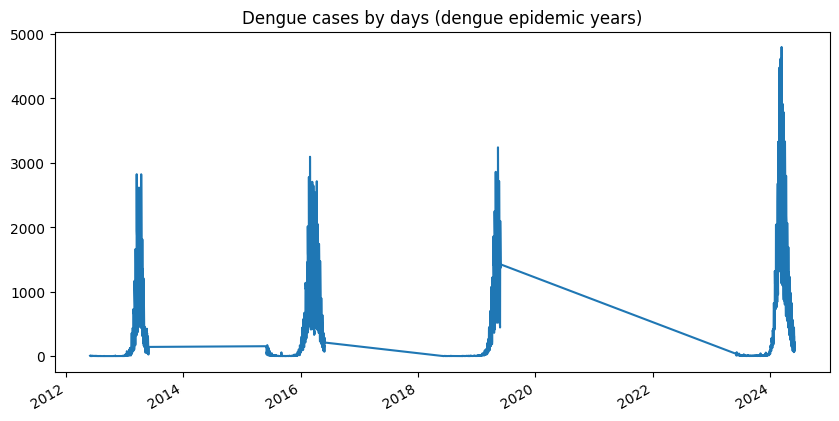

In [35]:
epidemic_mask_dengue = daily_dengue_data.index.map(lambda x: x in epidemy_days_flat_dengue)
daily_dengue_data_epidemic = daily_dengue_data[epidemic_mask_dengue]
daily_dengue_data_epidemic.plot(kind='line', figsize=(10, 5), title='Dengue cases by days (dengue epidemic years)')
daily_dengue_data_epidemic.index = daily_dengue_data_epidemic.index.map(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))


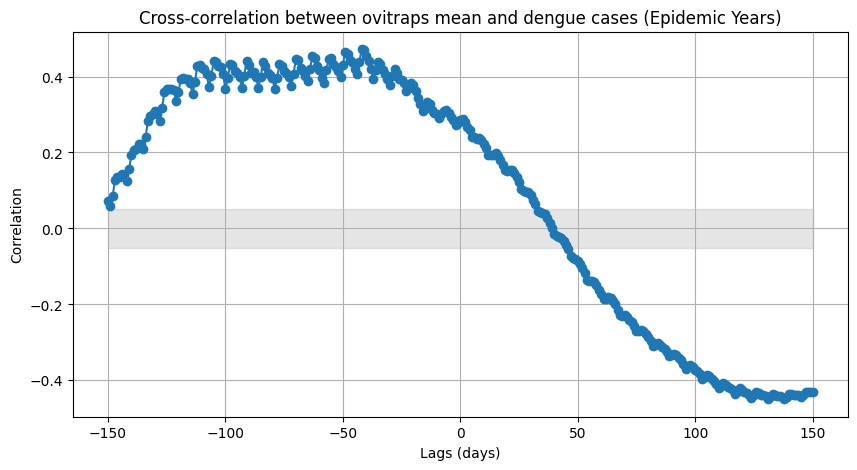

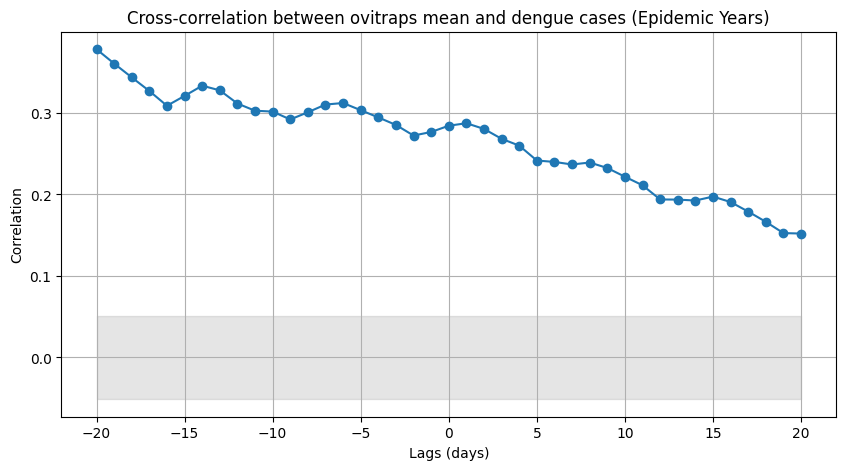

In [36]:
generic.plot_cross_correlation(
    series_1 = daily_ovitraps_mean,
    series_2 = daily_dengue_data_epidemic,
    max_lag =  150,
    title = 'Cross-correlation between ovitraps mean and dengue cases (Epidemic Years)',
    x_label = 'Lags (days)',
    )

generic.plot_cross_correlation(
    series_1 = daily_ovitraps_mean,
    series_2 = daily_dengue_data_epidemic,
    max_lag =  20,
    title = 'Cross-correlation between ovitraps mean and dengue cases (Epidemic Years)',
    x_label = 'Lags (days)',
    )

### Non epidemic years

<Axes: title={'center': 'Dengue cases by days (non-epidemy years - dengue)'}>

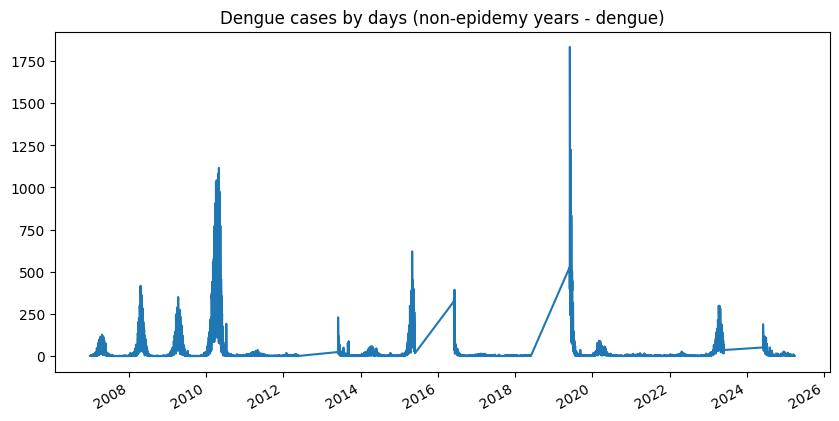

In [38]:
daily_dengue_data_non_epidemic = daily_dengue_data[~epidemic_mask_dengue]
daily_dengue_data_non_epidemic.index = daily_dengue_data_non_epidemic.index.map(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
daily_dengue_data_non_epidemic.plot(kind='line', figsize=(10, 5), title='Dengue cases by days (non-epidemy years - dengue)')


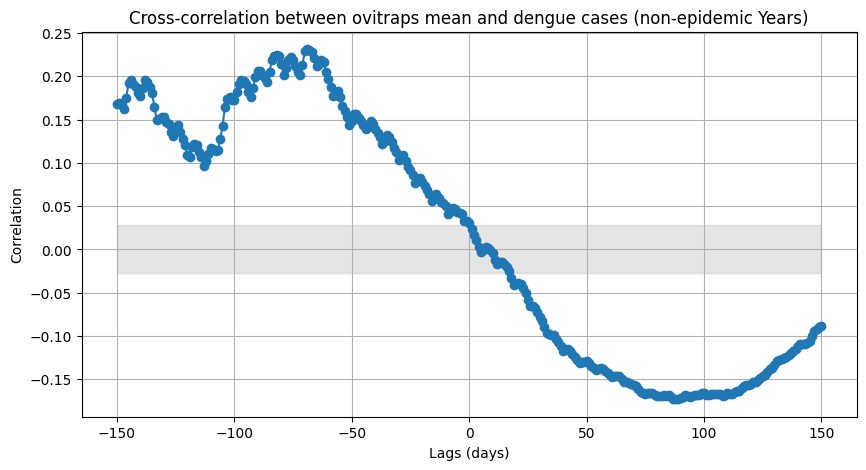

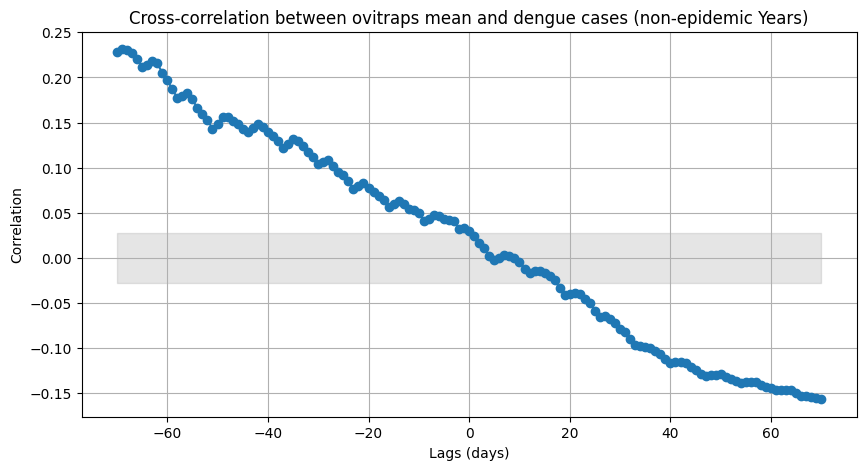

In [39]:
# Filter non epidemic years
generic.plot_cross_correlation(
    series_1 = daily_ovitraps_mean,
    series_2 = daily_dengue_data_non_epidemic,
    max_lag =  150,
    title = 'Cross-correlation between ovitraps mean and dengue cases (non-epidemic Years)',
    x_label = 'Lags (days)',
    )

generic.plot_cross_correlation(
    series_1 = daily_ovitraps_mean,
    series_2 = daily_dengue_data_non_epidemic,
    max_lag =  70,
    title = 'Cross-correlation between ovitraps mean and dengue cases (non-epidemic Years)',
    x_label = 'Lags (days)',
    )

### Correlation by year

Skipping year 2006_07 due to error: Both series must have at least one valid value to calculate correlation.
Skipping year 2007_08 due to error: Both series must have at least one valid value to calculate correlation.
Skipping year 2008_09 due to error: Both series must have at least one valid value to calculate correlation.
Skipping year 2009_10 due to error: Both series must have at least one valid value to calculate correlation.
Skipping year 2010_11 due to error: Both series must have at least one valid value to calculate correlation.


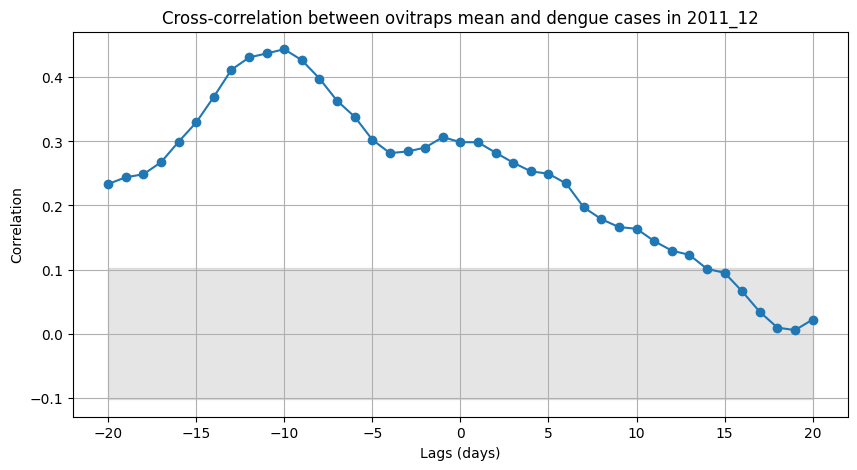

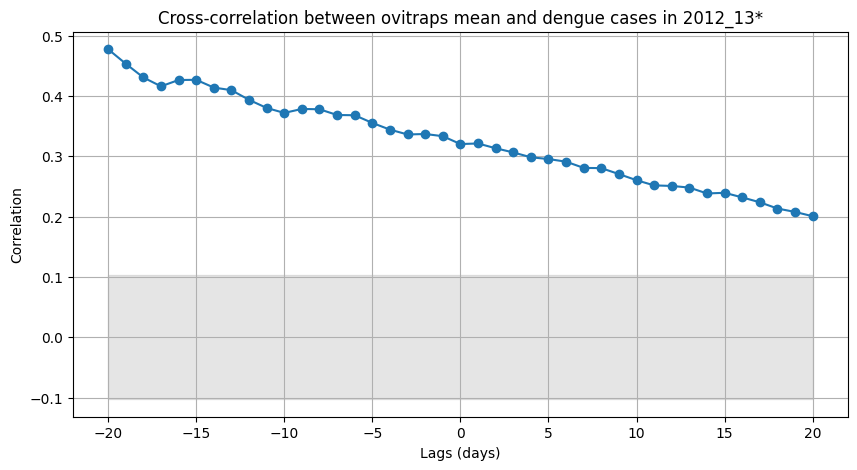

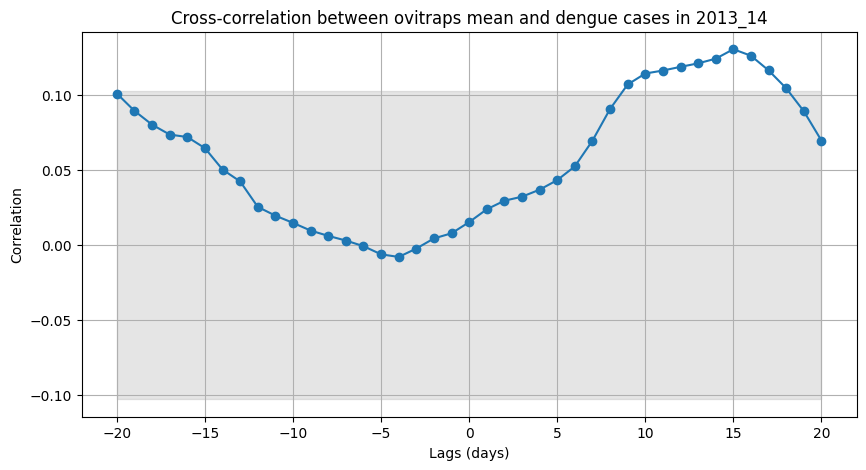

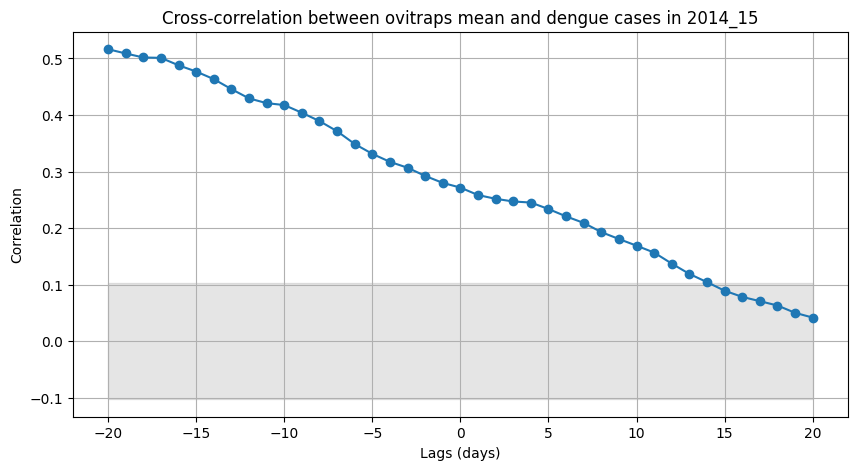

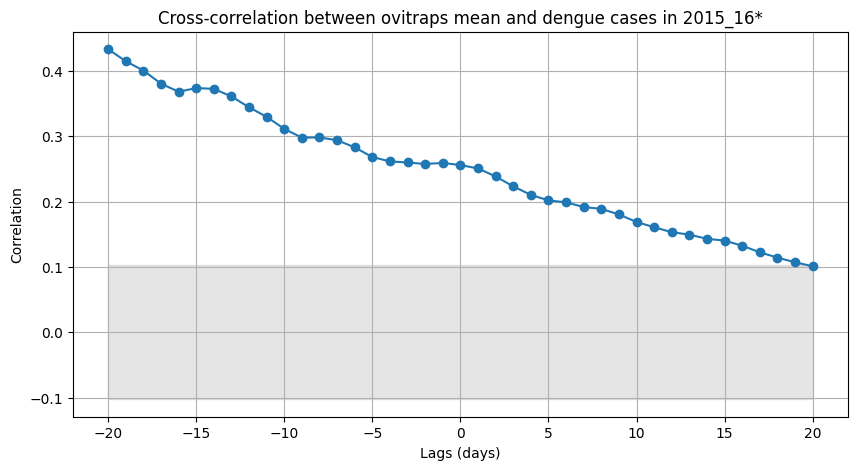

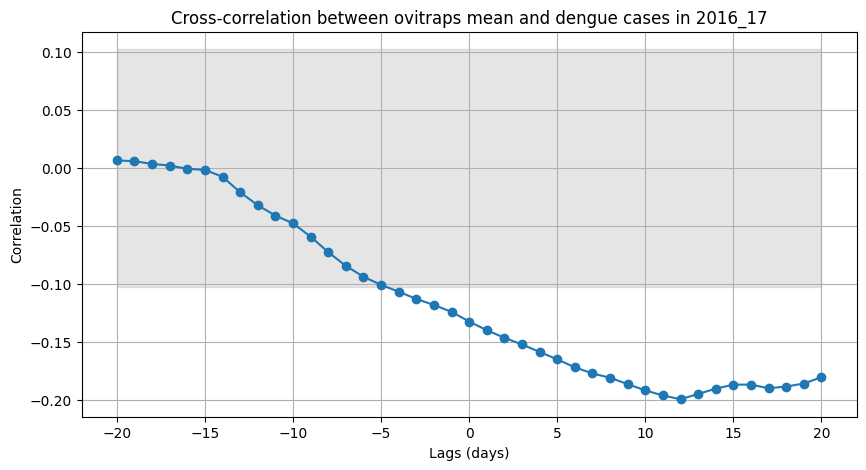

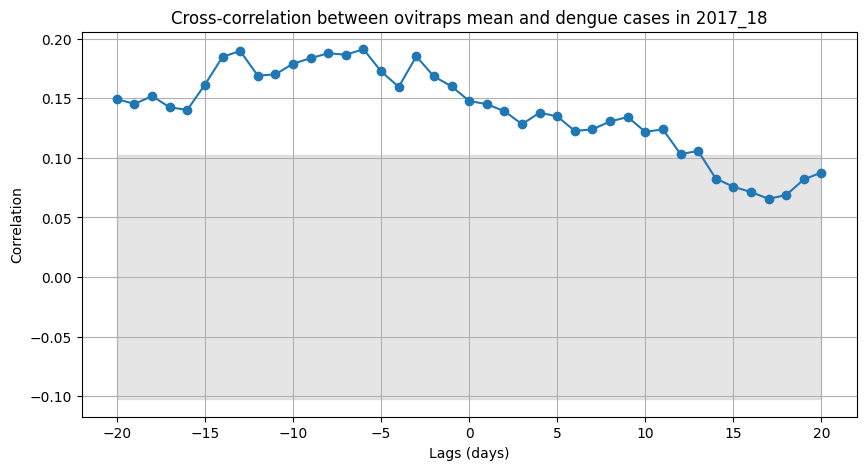

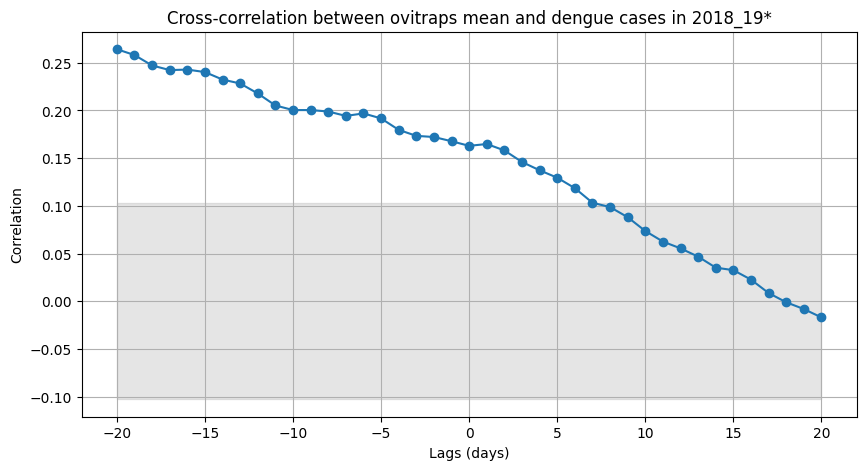

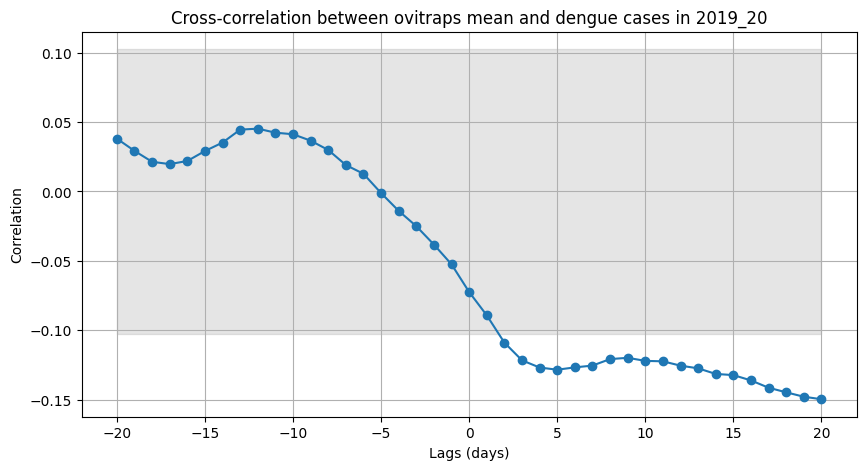

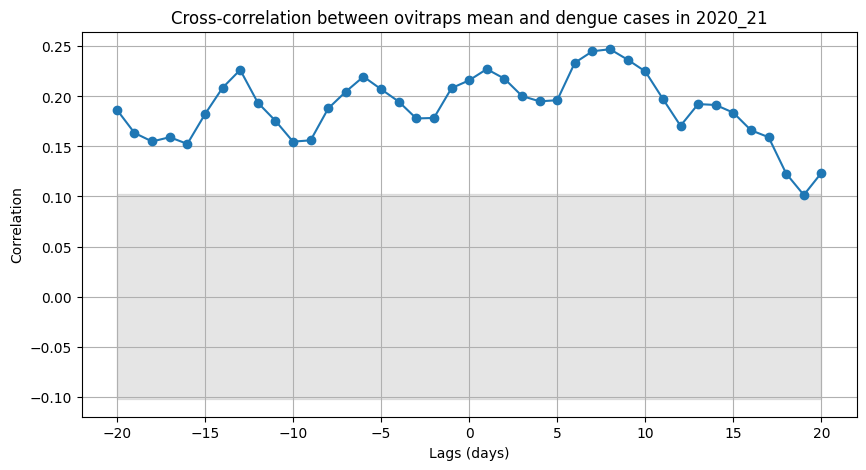

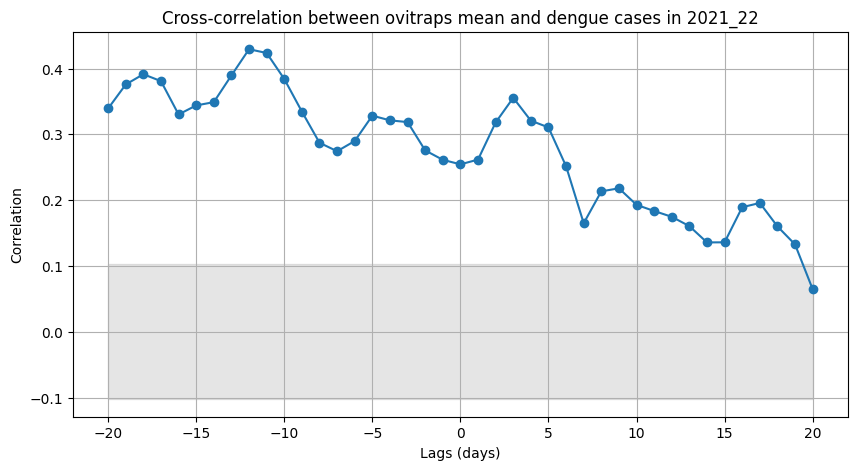

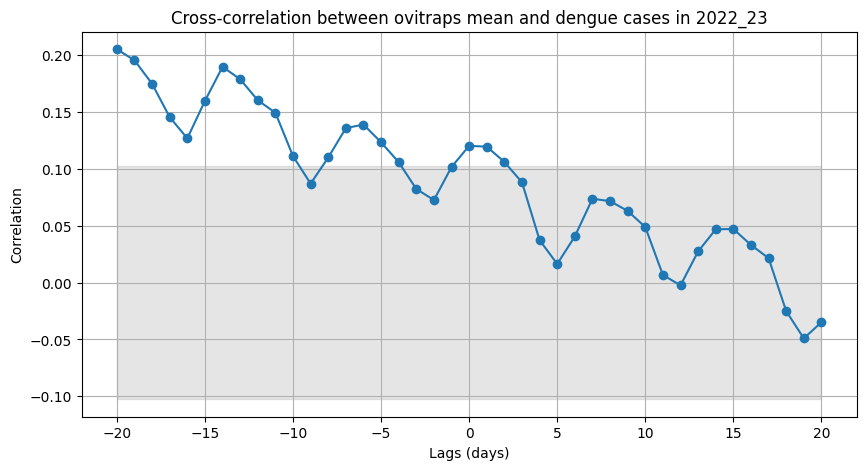

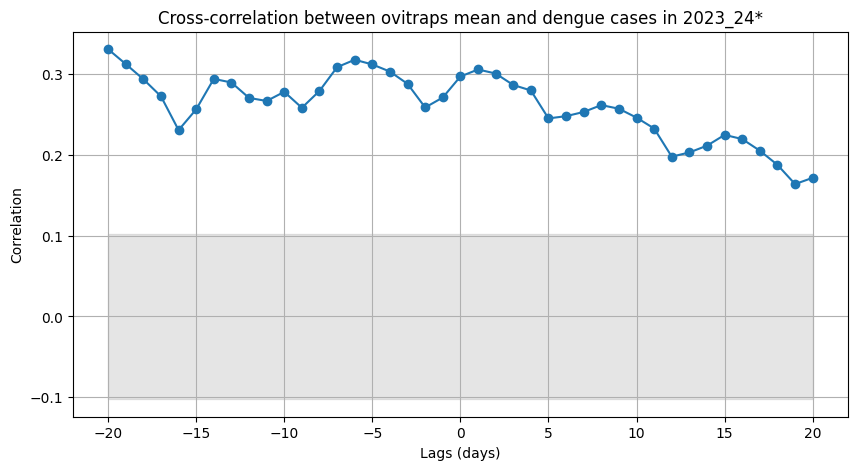

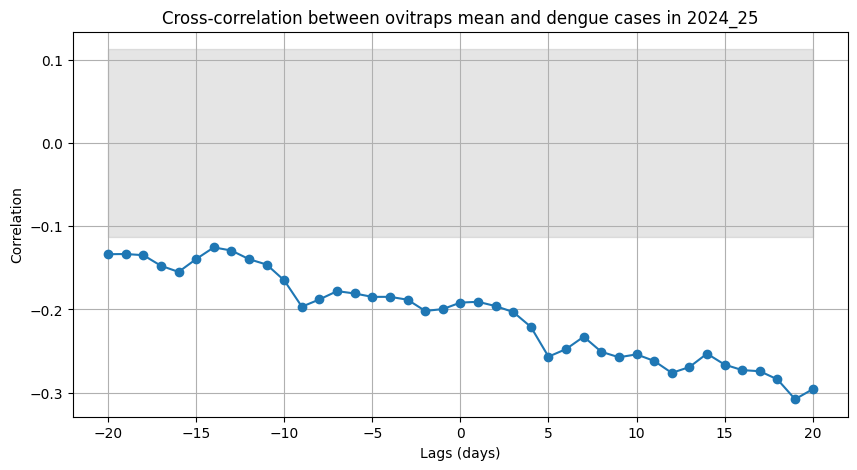

In [40]:
all_years = dengue_data.anoepid.unique()
all_years.sort()
max_correlation_dict = {}
for year in all_years:

    year_data = daily_dengue_data[daily_dengue_data_with_anoepid['anoepid'] == year]
    try:
        if year in epidemy_years:
            marker = '*'
        else:
            marker = ''    
        # Plot cross-correlation for each year
        generic.plot_cross_correlation(
            series_1 = daily_ovitraps_mean,
            series_2 = year_data,
            max_lag =  20,
            title = f'Cross-correlation between ovitraps mean and dengue cases in {year}{marker}',
            x_label = 'Lags (days)',
            )
        plt.show()
        
        # Get the maximum correlation for each year
        max_correlation_dict[year] = generic.max_correlation(
                                    series_1 = daily_ovitraps_mean,
                                    series_2 = year_data,
                                    max_lag =  50,
                                            )
    except ValueError as e:
        print(f"Skipping year {year} due to error: {e}")
        continue

## Maximum correlation

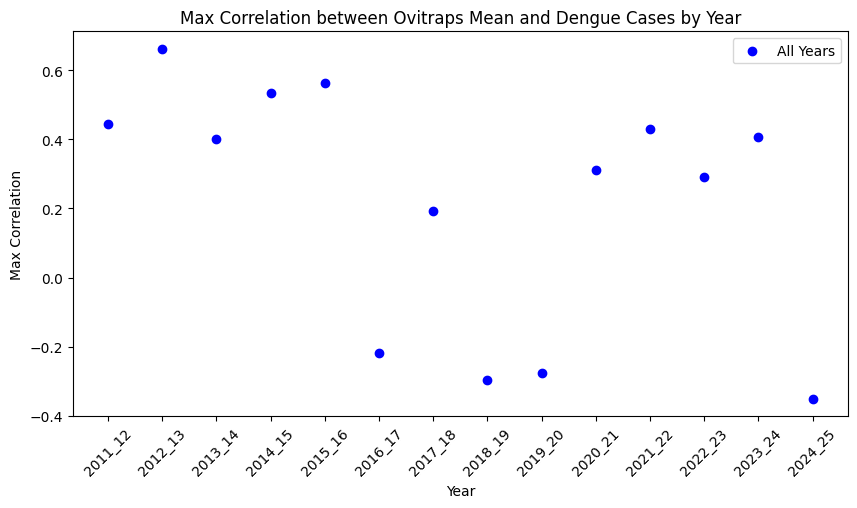

In [41]:
# Plot max correlations for all years
plt.figure(figsize=(10, 5))
plt.scatter(max_correlation_dict.keys(), [v[1] for v in max_correlation_dict.values()], color='blue', label='All Years')
plt.ylabel('Max Correlation')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.legend()
plt.title('Max Correlation between Ovitraps Mean and Dengue Cases by Year')
plt.show()


# Scatter Plots

### All years

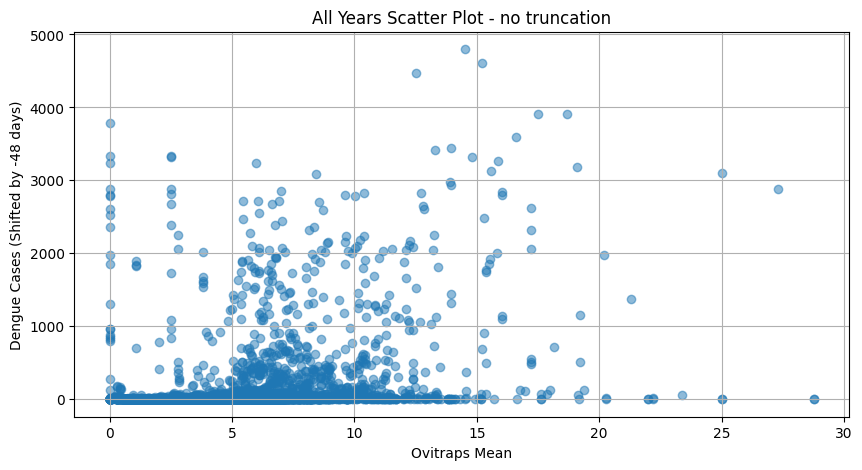

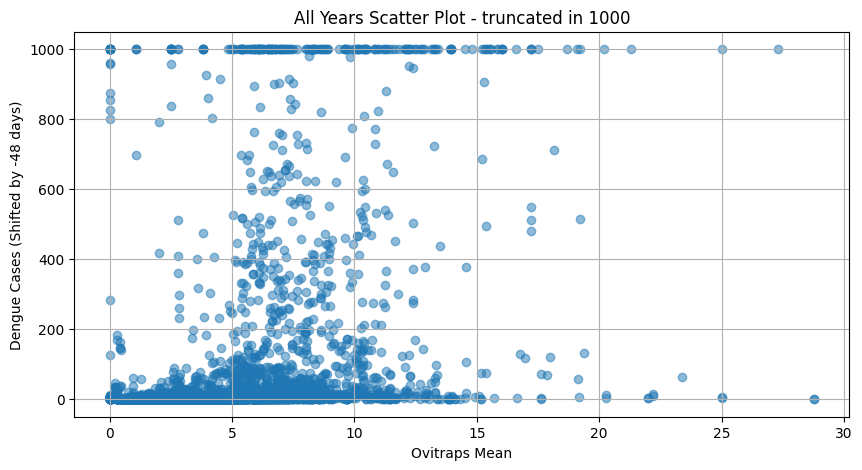

c:\Users\User\miniconda3\envs\venv_ovitraps\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


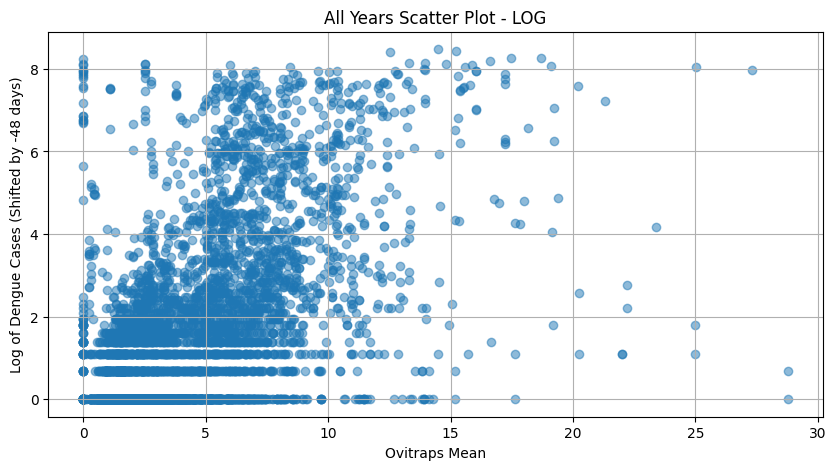

In [42]:
shift = -48

generic.two_series_scatter_plot(daily_ovitraps_mean,
                                daily_dengue_data,
                                series_2_shift = shift,
                                title = 'All Years Scatter Plot - no truncation',
                                xlabel='Ovitraps Mean',
                                ylabel=f'Dengue Cases (Shifted by {shift} days)',
                                )   

generic.two_series_scatter_plot(daily_ovitraps_mean,
                                daily_dengue_data.clip(upper=1000),
                                series_2_shift = shift,
                                title = 'All Years Scatter Plot - truncated in 1000',
                                xlabel='Ovitraps Mean',
                                ylabel=f'Dengue Cases (Shifted by {shift} days)',
                                )   

generic.two_series_scatter_plot(daily_ovitraps_mean,
                                np.log(daily_dengue_data).replace(-np.inf, 0),
                                series_2_shift = shift,
                                title = 'All Years Scatter Plot - LOG',
                                xlabel='Ovitraps Mean',
                                ylabel=f'Log of Dengue Cases (Shifted by {shift} days)',
                                )   

### Epidemic years

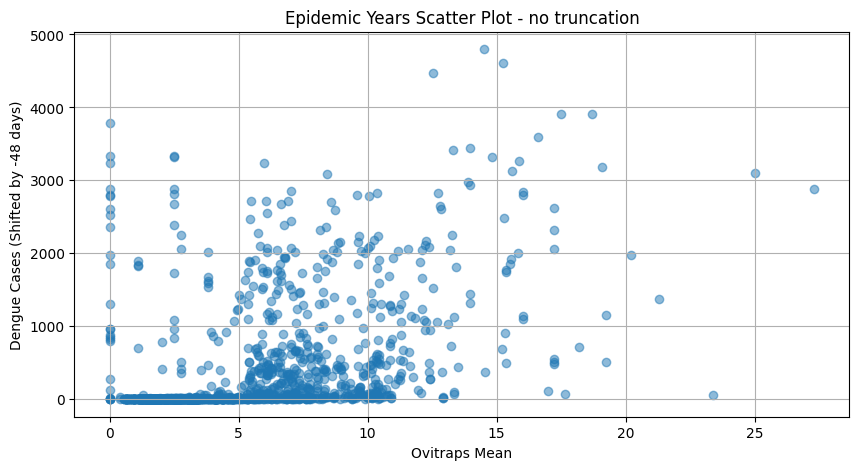

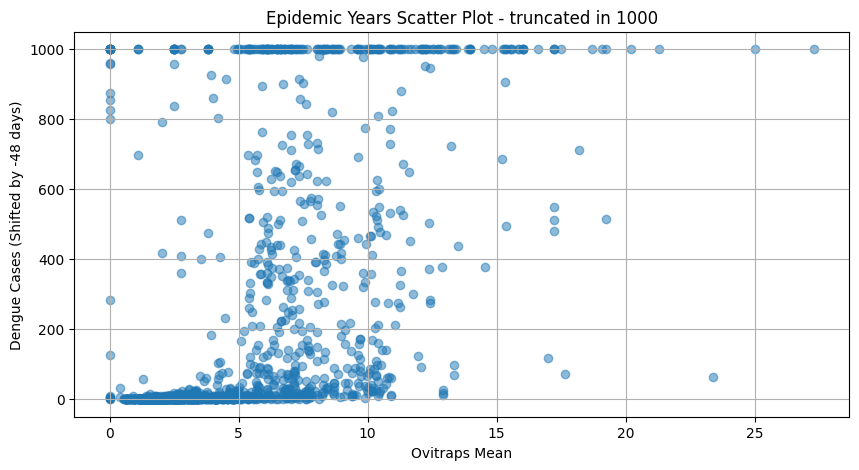

c:\Users\User\miniconda3\envs\venv_ovitraps\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


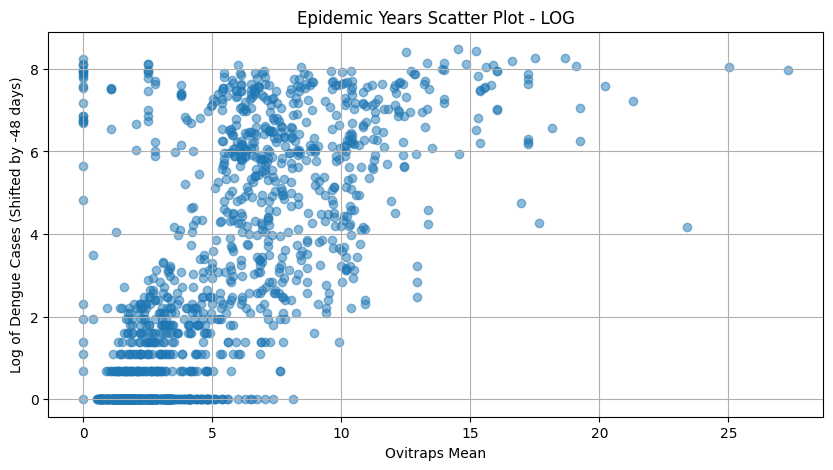

In [43]:
shift = -48

generic.two_series_scatter_plot(daily_ovitraps_mean,
                                daily_dengue_data_epidemic,
                                series_2_shift = shift,
                                title = 'Epidemic Years Scatter Plot - no truncation',
                                xlabel='Ovitraps Mean',
                                ylabel=f'Dengue Cases (Shifted by {shift} days)',
                                )   

generic.two_series_scatter_plot(daily_ovitraps_mean,
                                daily_dengue_data_epidemic.clip(upper=1000),
                                series_2_shift = shift,
                                title = 'Epidemic Years Scatter Plot - truncated in 1000',
                                xlabel='Ovitraps Mean',
                                ylabel=f'Dengue Cases (Shifted by {shift} days)',
                                )   

generic.two_series_scatter_plot(daily_ovitraps_mean,
                                np.log(daily_dengue_data_epidemic).replace(-np.inf, 0),
                                series_2_shift = shift,
                                title = 'Epidemic Years Scatter Plot - LOG',
                                xlabel='Ovitraps Mean',
                                ylabel=f'Log of Dengue Cases (Shifted by {shift} days)',
                                )   

### Non epidemic years

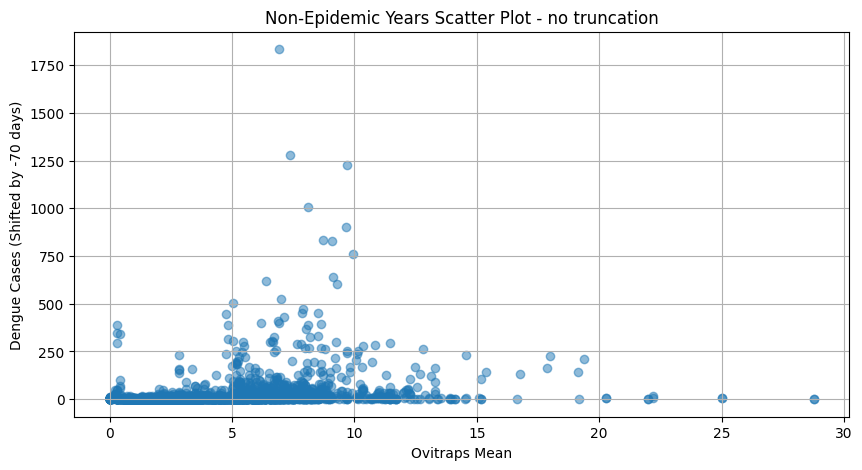

In [44]:
shift = -70

generic.two_series_scatter_plot(daily_ovitraps_mean,
                                daily_dengue_data_non_epidemic,
                                series_2_shift = shift,
                                title = 'Non-Epidemic Years Scatter Plot - no truncation',
                                xlabel='Ovitraps Mean',
                                ylabel=f'Dengue Cases (Shifted by {shift} days)',
                                )   


### Year by year

Skipping year 2006_07 due to error: Both series must have at least one valid value to plot.
Skipping year 2007_08 due to error: Both series must have at least one valid value to plot.
Skipping year 2008_09 due to error: Both series must have at least one valid value to plot.
Skipping year 2009_10 due to error: Both series must have at least one valid value to plot.
Skipping year 2010_11 due to error: Both series must have at least one valid value to plot.


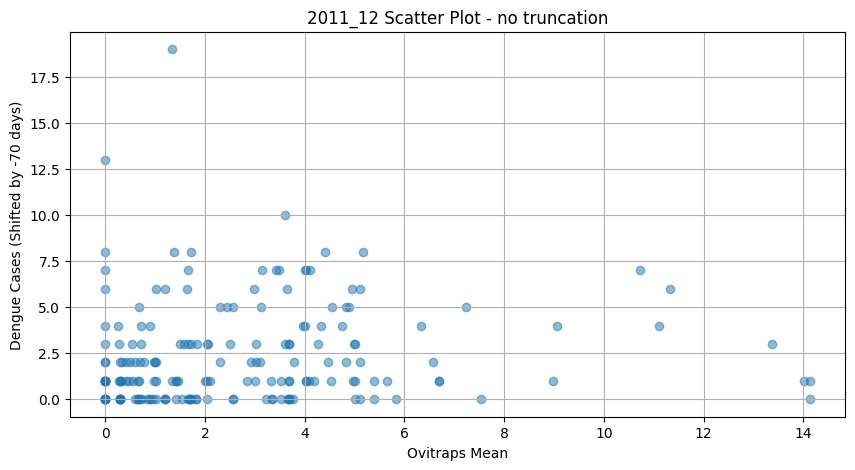

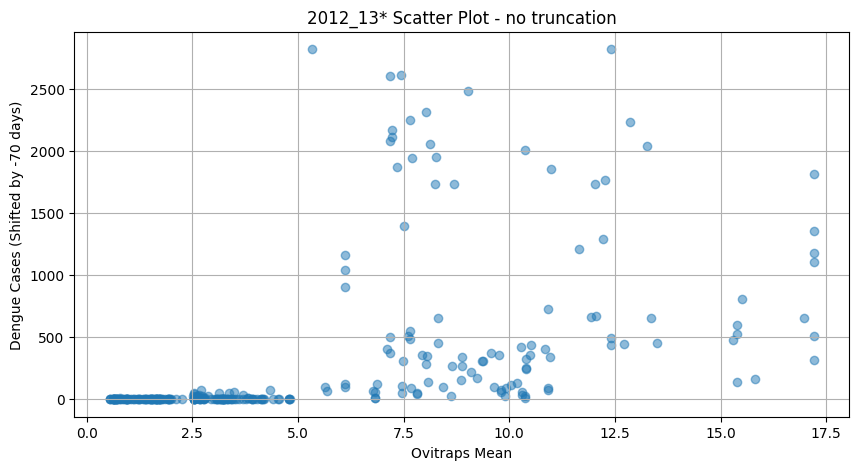

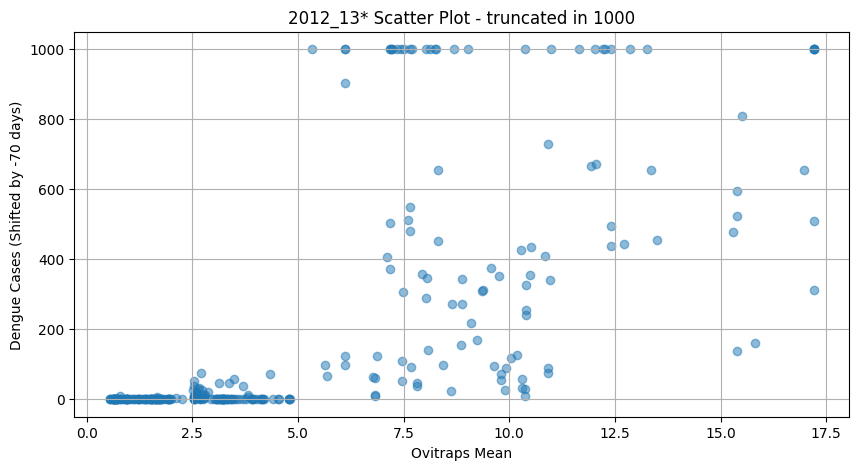

c:\Users\User\miniconda3\envs\venv_ovitraps\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


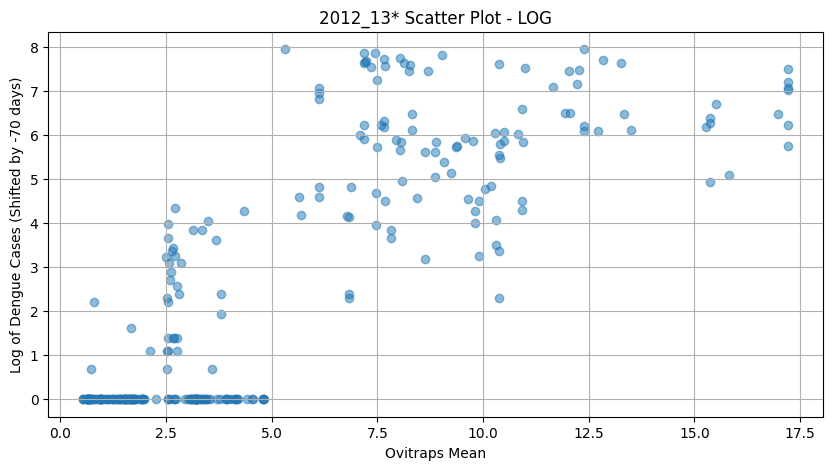

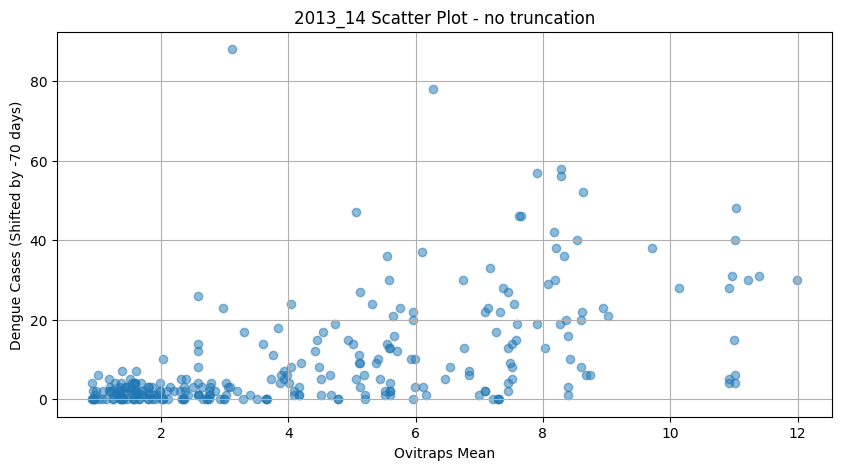

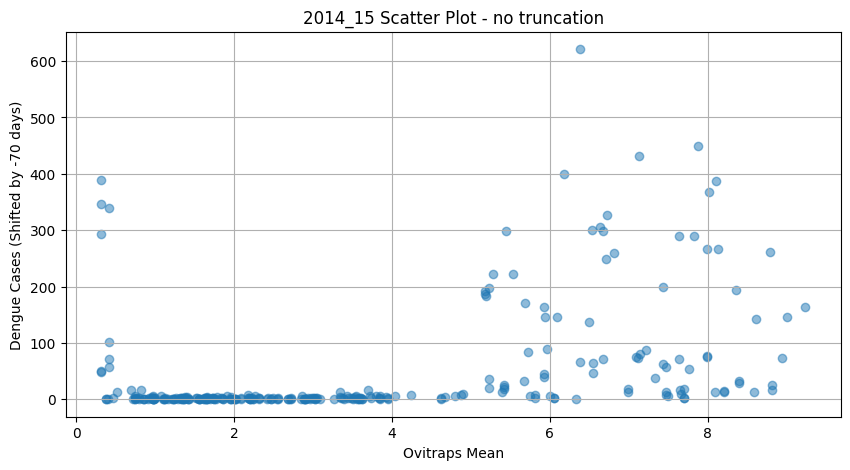

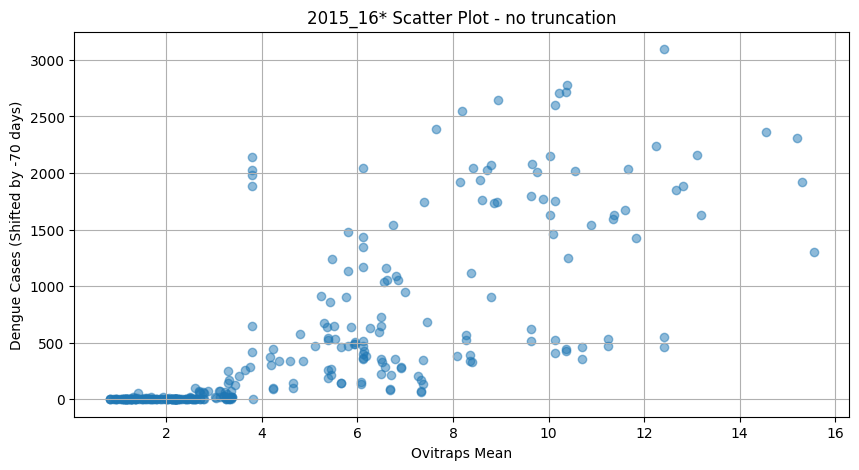

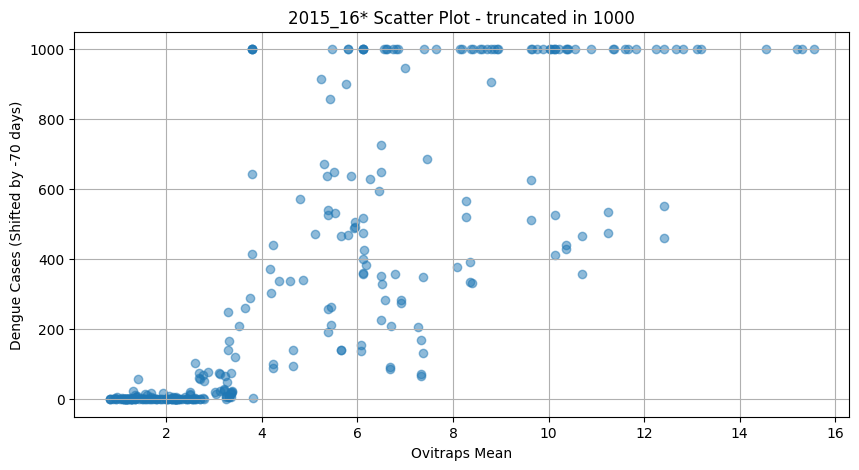

c:\Users\User\miniconda3\envs\venv_ovitraps\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


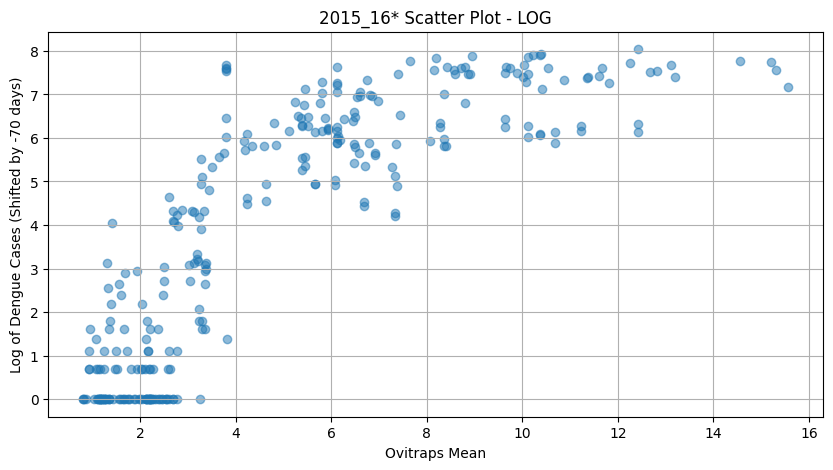

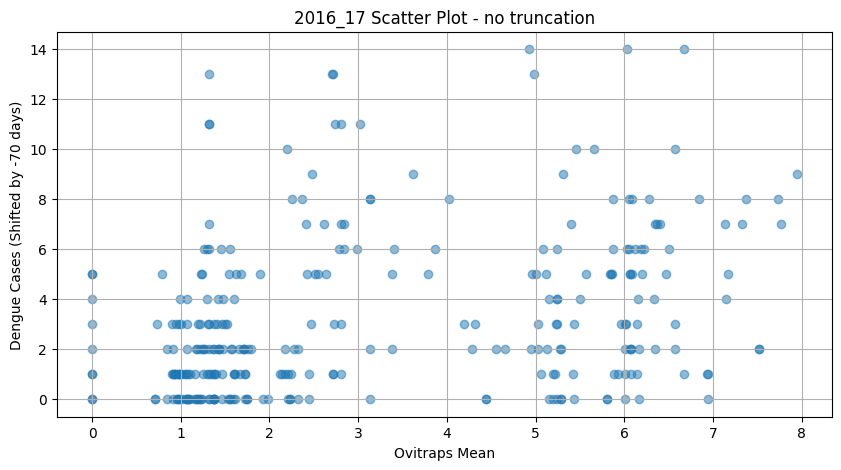

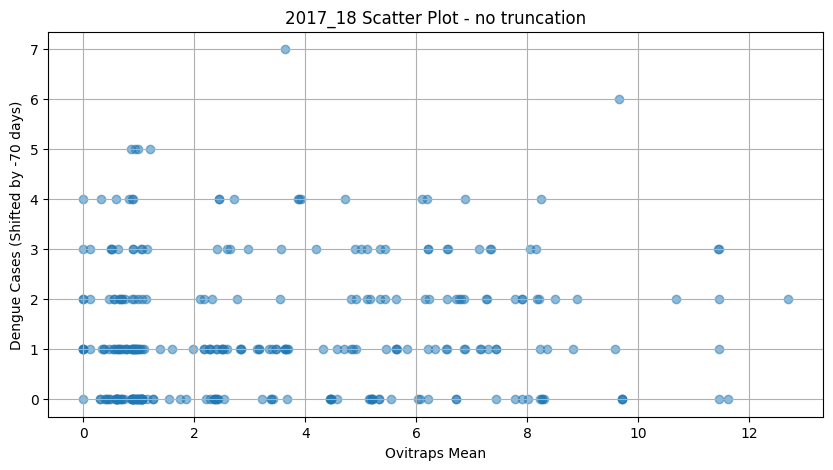

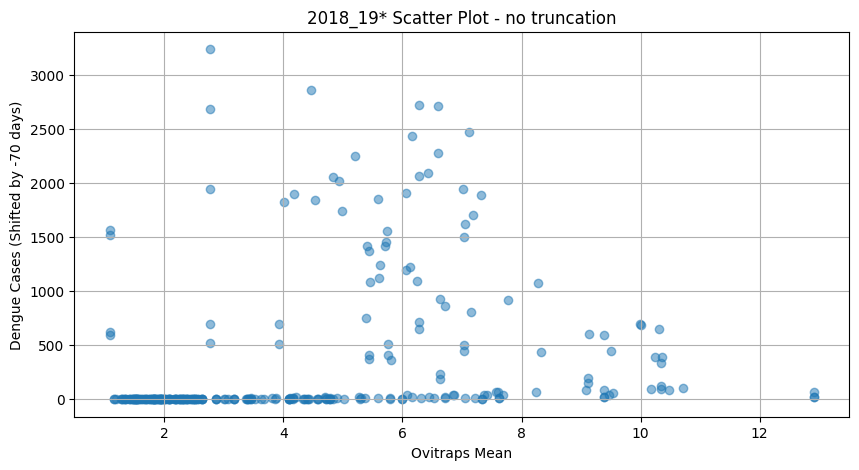

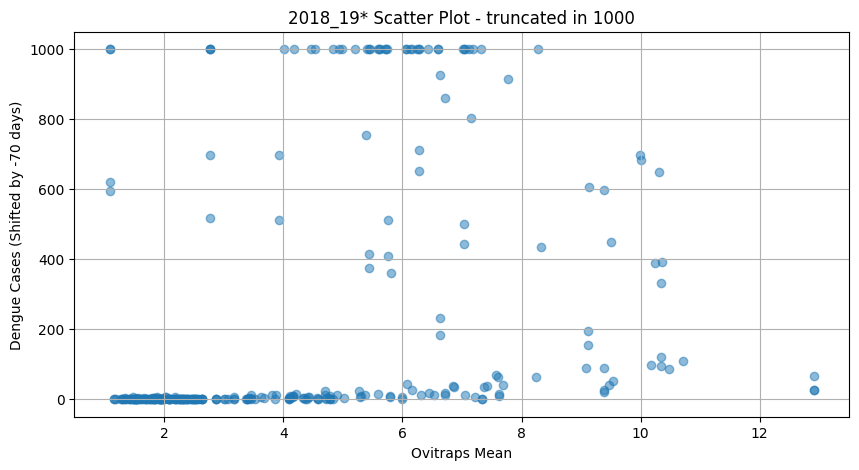

c:\Users\User\miniconda3\envs\venv_ovitraps\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


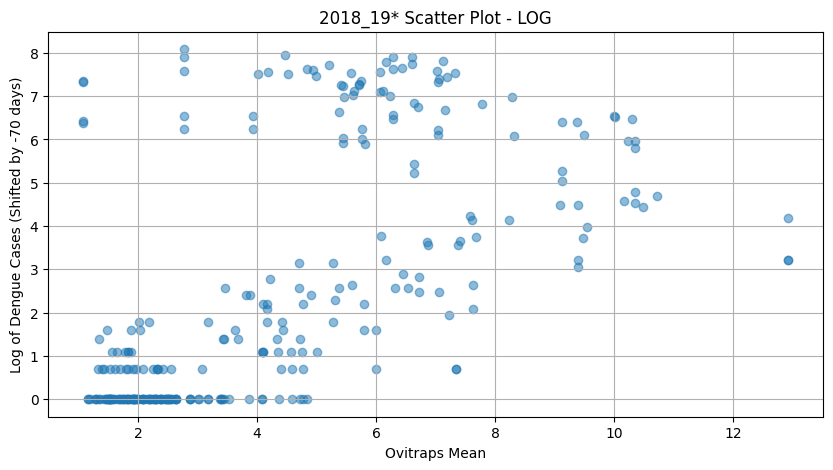

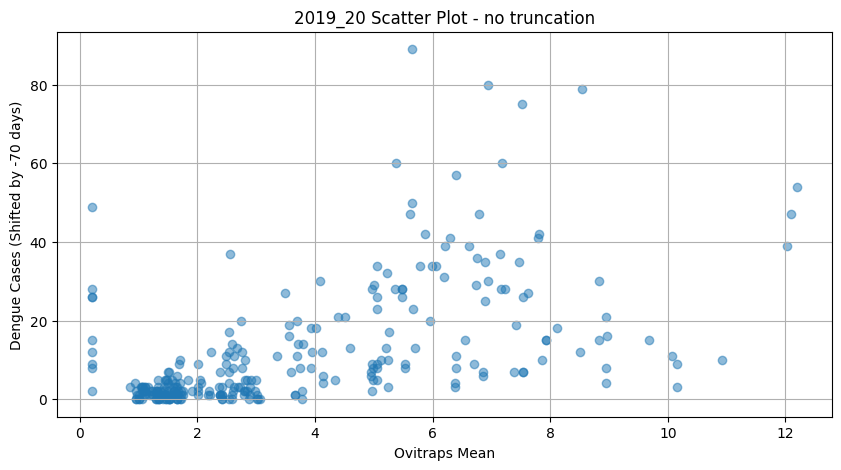

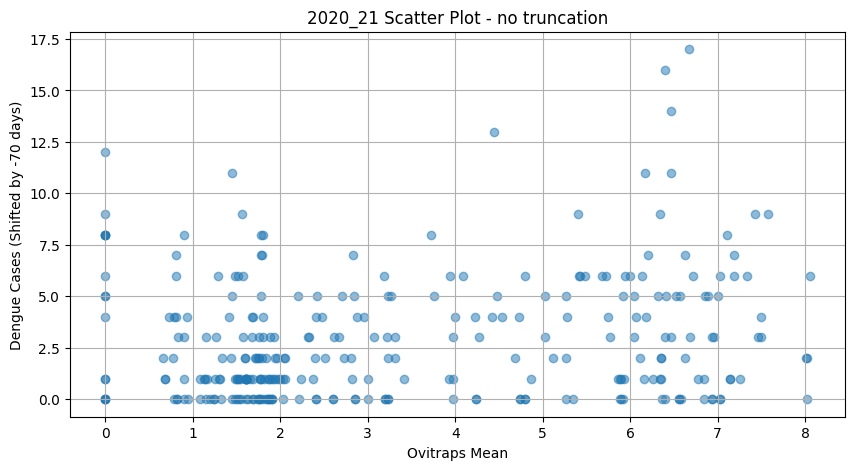

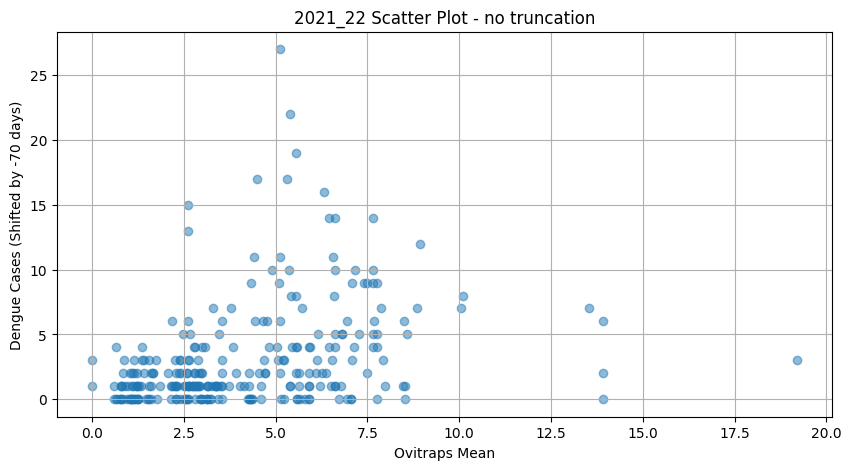

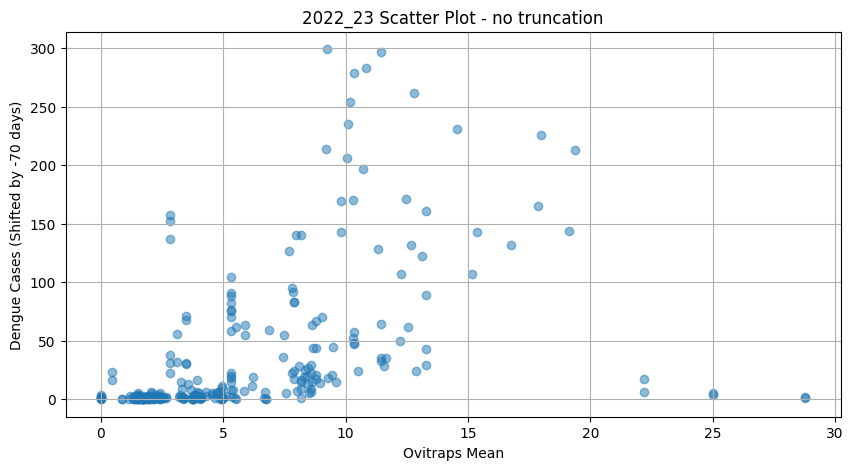

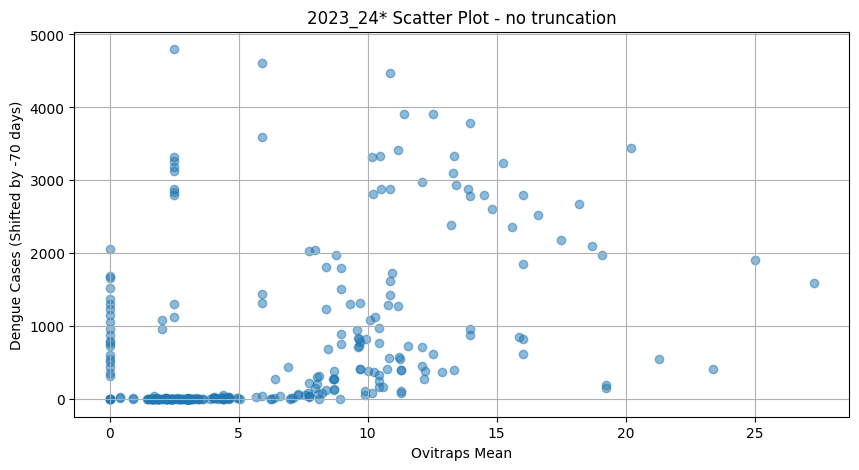

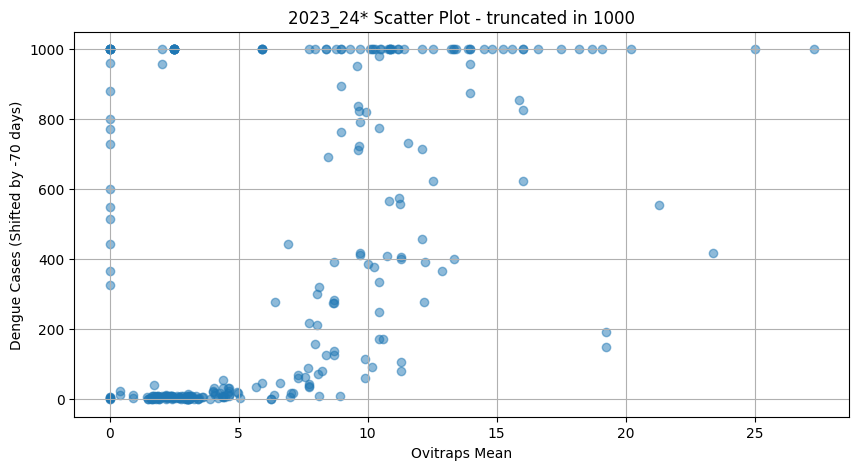

c:\Users\User\miniconda3\envs\venv_ovitraps\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


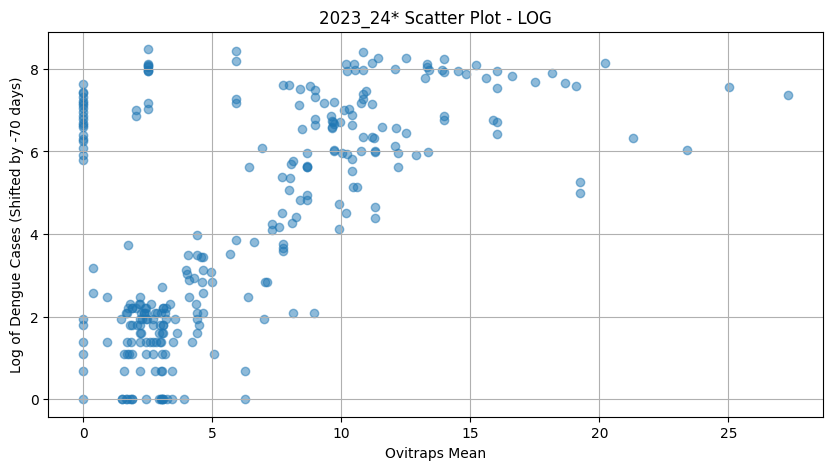

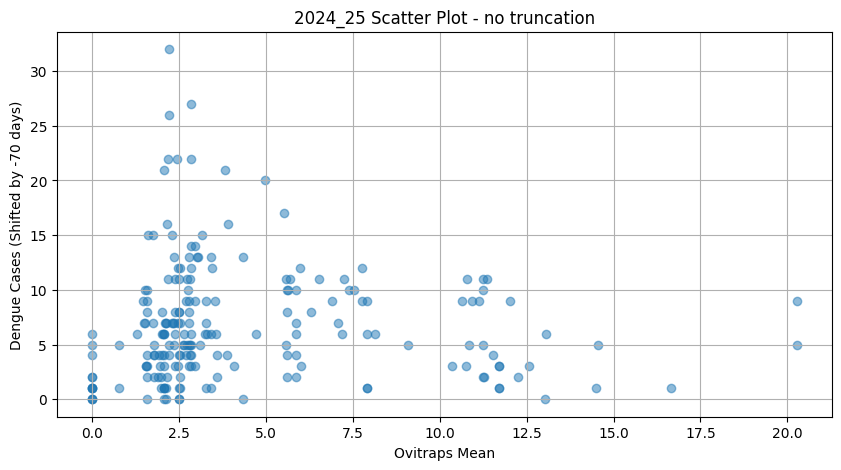

In [45]:
all_years = dengue_data.anoepid.unique()
all_years.sort()
max_correlation_dict = {}
for year in all_years:
    year_data = daily_dengue_data[daily_dengue_data_with_anoepid['anoepid'] == year]
    try:
        if year in epidemy_years:

            marker = '*'
        else:
            marker = ''    
        # Plot cross-correlation for each year
        generic.two_series_scatter_plot(daily_ovitraps_mean,
                                year_data,
                                series_2_shift = shift,
                                title = f'{year}{marker} Scatter Plot - no truncation',
                                xlabel='Ovitraps Mean',
                                ylabel=f'Dengue Cases (Shifted by {shift} days)',
                                )  
        if year in epidemy_years:
            generic.two_series_scatter_plot(daily_ovitraps_mean,
                                    year_data.clip(upper=1000),
                                    series_2_shift = shift,
                                    title = f'{year}{marker} Scatter Plot - truncated in 1000',
                                    xlabel='Ovitraps Mean',
                                    ylabel=f'Dengue Cases (Shifted by {shift} days)',
                                    )  
            
            generic.two_series_scatter_plot(daily_ovitraps_mean,
                                np.log(year_data).replace(-np.inf, 0),
                                series_2_shift = shift,
                                title =  f'{year}{marker} Scatter Plot - LOG',
                                xlabel='Ovitraps Mean',
                                ylabel=f'Log of Dengue Cases (Shifted by {shift} days)',
                                )    
    except ValueError as e:
        print(f"Skipping year {year} due to error: {e}")
        continue

# Box-plot

In [46]:
daily_ovitraps_mean_shifted = daily_ovitraps_mean.shift(48)


## All years

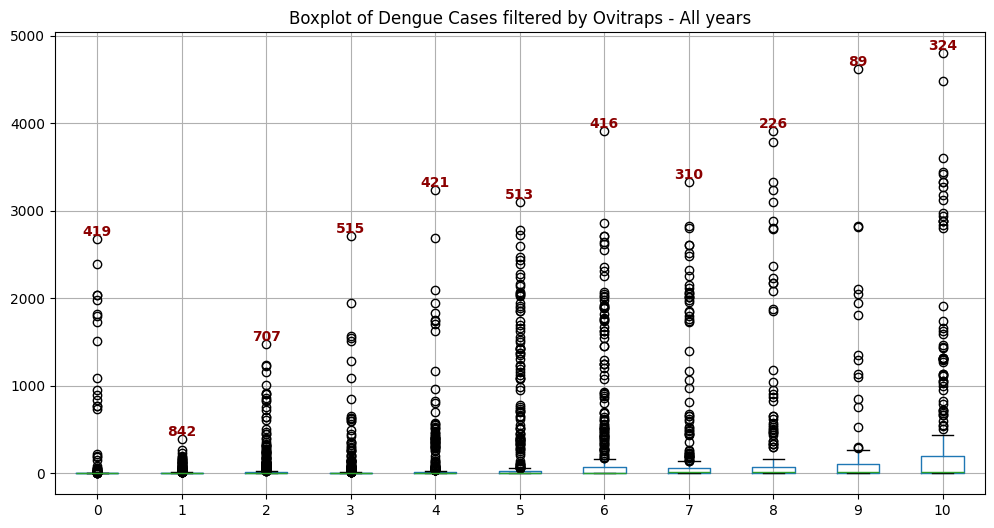

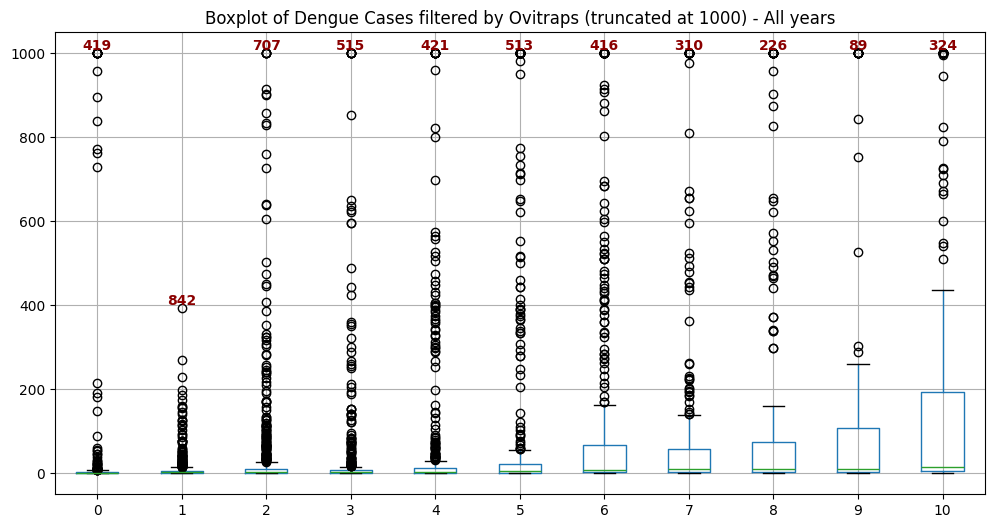

In [47]:
filtered_df_all = pd.DataFrame()
filtered_series = []
for down,up in zip(range(0,11), range(1,12)):
    if up > 10:
        up = np.inf
    filter_index = daily_ovitraps_mean[(daily_ovitraps_mean < up) & (daily_ovitraps_mean >= down)].dropna().index
    filtered_series.append(pd.Series(daily_dengue_data.loc[daily_dengue_data.index.intersection(filter_index)].dropna(),name=f'{down}'))

filtered_df_all = pd.DataFrame(filtered_series).T
cat_samples = filtered_df_all.notna().sum()

# Plot
plt.figure(figsize=(12, 6))
ax = filtered_df_all.boxplot()
# Add text above each box
for i, col in enumerate(filtered_df_all.columns, start=1):
    ax.text(
        i,                      # x = box position
        filtered_df_all[col].max(),  # y = max value of that box
        str(cat_samples[col]),       # text = count
        ha='center', va='bottom',
        fontsize=10, fontweight='bold', color='darkred'
    )
plt.title('Boxplot of Dengue Cases filtered by Ovitraps - All years')
plt.show()

plt.figure(figsize=(12, 6))
ax = filtered_df_all.clip(upper=1000).boxplot()
# Add text above each box
for i, col in enumerate(filtered_df_all.columns, start=1):
    ax.text(
        i,                      # x = box position
        filtered_df_all[col].clip(upper=1000).max(),  # y = max value of that box
        str(cat_samples[col]),       # text = count
        ha='center', va='bottom',
        fontsize=10, fontweight='bold', color='darkred'
    )
plt.title('Boxplot of Dengue Cases filtered by Ovitraps (truncated at 1000) - All years')
plt.show()

## Epidemy Years

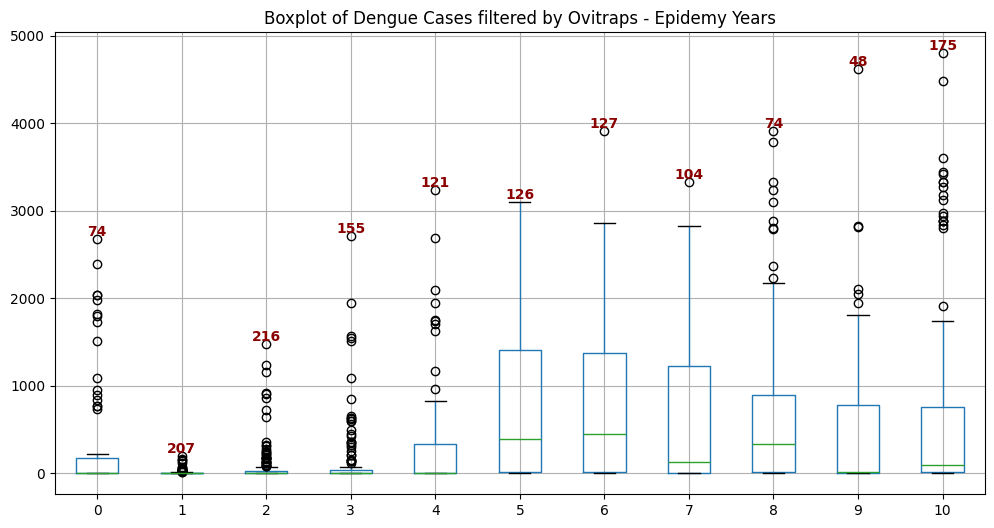

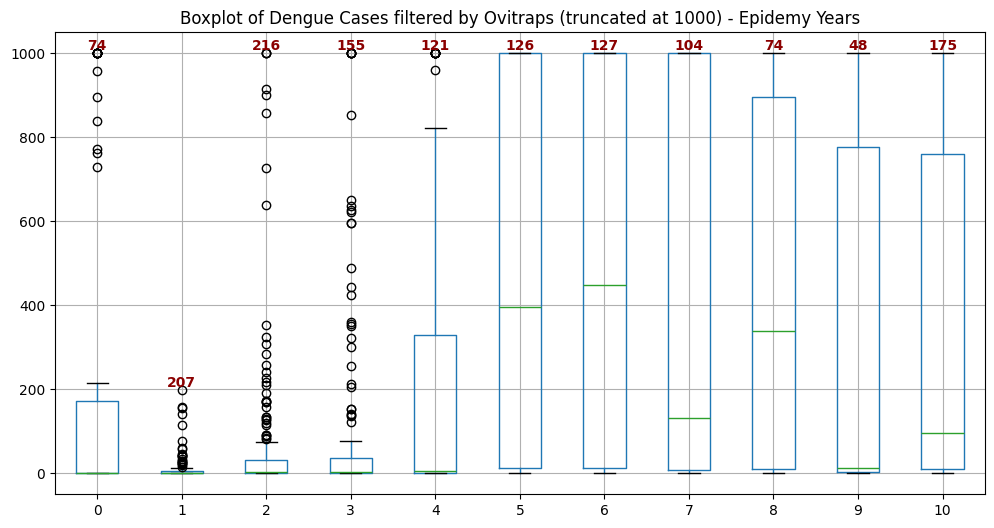

In [48]:
filtered_series = []
for down,up in zip(range(0,11), range(1,12)):
    if up > 10:
        up = np.inf
    filter_index = daily_ovitraps_mean[(daily_ovitraps_mean < up) & (daily_ovitraps_mean >= down)].dropna().index
    filtered_series.append(pd.Series(daily_dengue_data_epidemic.loc[daily_dengue_data_epidemic.index.intersection(filter_index)].dropna(),name=f'{down}'))

filtered_df_epidemy = pd.DataFrame(filtered_series).T
cat_samples = filtered_df_epidemy.notna().sum()

# Plot
plt.figure(figsize=(12, 6))
# Add the text inside the plot (adjust x, y as needed)
ax = filtered_df_epidemy.boxplot()

# Add text above each box
for i, col in enumerate(filtered_df_epidemy.columns, start=1):
    ax.text(
        i,                      # x = box position
        filtered_df_epidemy[col].max(),  # y = max value of that box
        str(cat_samples[col]),       # text = count
        ha='center', va='bottom',
        fontsize=10, fontweight='bold', color='darkred'
    )
plt.title('Boxplot of Dengue Cases filtered by Ovitraps - Epidemy Years')
plt.show()


plt.figure(figsize=(12, 6))
# Add the text inside the plot (adjust x, y as needed)
ax = filtered_df_epidemy.clip(upper=1000).boxplot()
# Add text above each box
for i, col in enumerate(filtered_df_epidemy.columns, start=1):
    ax.text(
        i,                      # x = box position
        filtered_df_epidemy[col].clip(upper=1000).max(),  # y = max value of that box
        str(cat_samples[col]),       # text = count
        ha='center', va='bottom',
        fontsize=10, fontweight='bold', color='darkred'
    )

plt.title('Boxplot of Dengue Cases filtered by Ovitraps (truncated at 1000) - Epidemy Years')
plt.show()

## Non-Epidemy Years

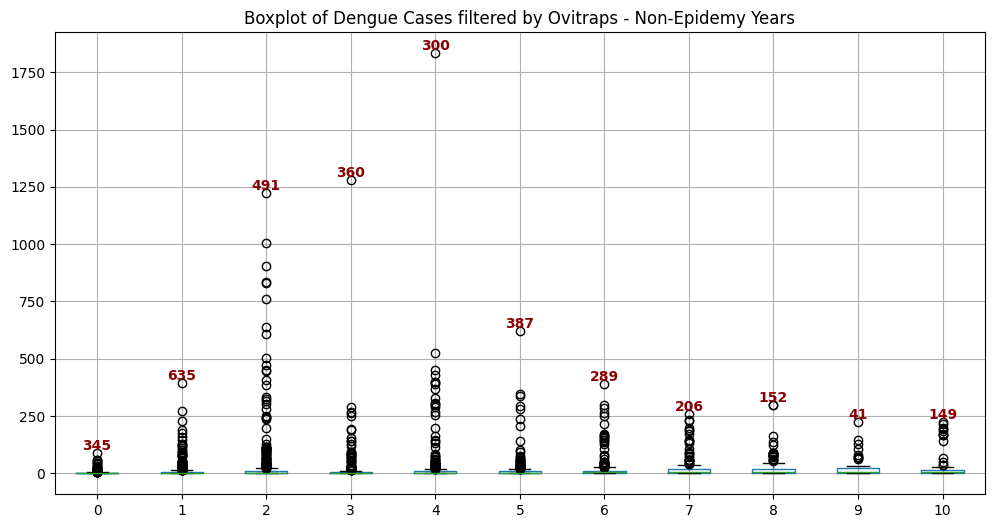

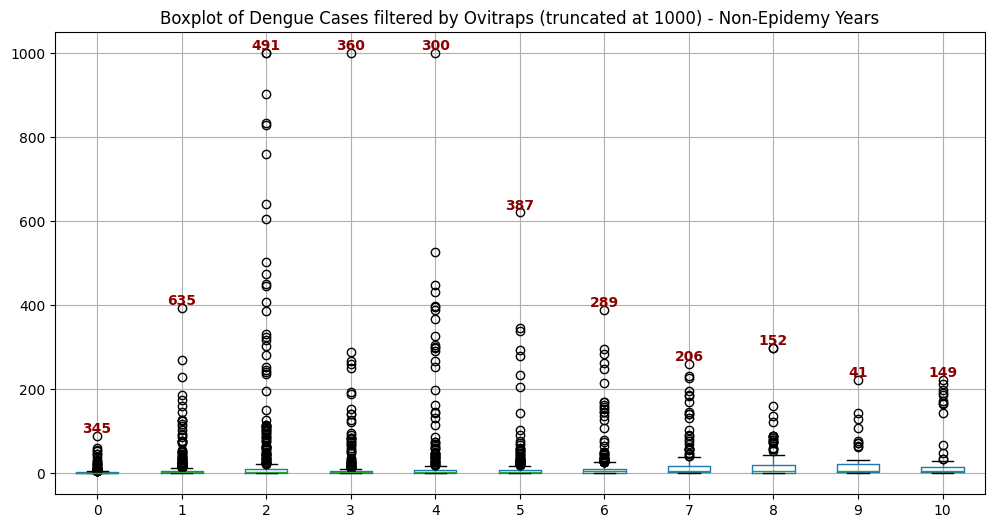

In [49]:
filtered_df_non_epidemy = pd.DataFrame()
filtered_series = []
for down,up in zip(range(0,11), range(1,12)):
    if up > 10:
        up = np.inf
    filter_index = daily_ovitraps_mean[(daily_ovitraps_mean < up) & (daily_ovitraps_mean >= down)].dropna().index
    filtered_series.append(pd.Series(daily_dengue_data_non_epidemic.loc[daily_dengue_data_non_epidemic.index.intersection(filter_index)].dropna(),name=f'{down}'))

filtered_df_non_epidemy = pd.DataFrame(filtered_series).T
cat_samples = filtered_df_non_epidemy.notna().sum()

# Plot
plt.figure(figsize=(12, 6))
ax = filtered_df_non_epidemy.boxplot()
# Add text above each box
for i, col in enumerate(filtered_df_non_epidemy.columns, start=1):
    ax.text(
        i,                      # x = box position
        filtered_df_non_epidemy[col].max(),  # y = max value of that box
        str(cat_samples[col]),       # text = count
        ha='center', va='bottom',
        fontsize=10, fontweight='bold', color='darkred'
    )

plt.title('Boxplot of Dengue Cases filtered by Ovitraps - Non-Epidemy Years')
plt.show()



plt.figure(figsize=(12, 6))
ax = filtered_df_non_epidemy.clip(upper=1000).boxplot()
# Add text above each box
for i, col in enumerate(filtered_df_non_epidemy.columns, start=1):
    ax.text(
        i,                      # x = box position
        filtered_df_non_epidemy[col].clip(upper=1000).max(),  # y = max value of that box
        str(cat_samples[col]),       # text = count
        ha='center', va='bottom',
        fontsize=10, fontweight='bold', color='darkred'
    )

plt.title('Boxplot of Dengue Cases filtered by Ovitraps (truncated at 1000) - Non-Epidemy Years')
plt.show()